# SSDLITE + MobileNetV3

In [237]:
from pathlib import Path
import os
import gc
import time
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# torch and CV tools
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from IPython.display import display


In [240]:
print(f'pytorch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')
print(f'Is cuda available?: {torch.cuda.is_available()}')

# using GPU if available, else using CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

pytorch version: 1.9.0
torchvision version: 0.10.0
Is cuda available?: True
Using device: cuda

Tesla T4
Memory Usage:
Allocated: 1.5 GB
Cached:    1.6 GB


In [239]:
# check cuda driver
!nvcc -V
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Wed Aug 11 17:30:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |   2845MiB / 15109MiB |      0%      Default |
|                               |         

# Dataset Facts  
**Dimensions (WxH)**<br>
Original videos: 1920x1080<br>
Extracted images: 384x216<br>
Note: both in ratio 16:9

**train/val/test splitted by device ID**
```python
train_devices = {'2801bb11-9cfd-49aa-b72e-f1c9b93e0cdc',
 '34644d19-1795-44be-801c-301800f38ef6',
 '42021c1a-9cd8-4d68-b381-244b97d92ce7',
 '4c074506-671d-4dfc-922b-363e7d3b0417',
 '6dcfb7de-c1a8-4de5-8207-869d7885e3e4',
 '6fd8b230-e30a-4fcc-8e5b-ccb94c272c53',
 '7b059082-a222-43f3-a3b5-3491499b4214',
 'a577c8d4-125a-43f2-b08c-02776f07434e',
 'c18cebb5-029e-4fcc-97b0-ad16cffc0723',
 'd5131db4-39c6-47b3-8c5f-d6b115c10c5f',
 'd7cc3ecf-cb8a-405f-87fb-8b4250f06465',
 'db8df8ac-05f1-4353-9bb6-6bfcdbea5a96',
 'dbe7a8ae-315c-45c7-9f5b-e69bb093e6f6',
 'e66062f7-d90b-48a0-a433-5eb09854b3f9',
 'ed813e3d-205c-48c8-b5bf-159e342a0b55',
 'fc8ed79e-7df9-407d-beee-2c480e0cabb2'}
val_devices = {'1fd6287d-4406-4860-8d04-c99230e43616',
 '381865e7-3442-4008-b418-911b795835c5',
 '499c6ab9-0115-4112-b4a2-31e5bb94b901',
 '9569597a-83c3-4968-af3c-31f295fce82a',
 'c8224a07-983b-47fa-a89b-e8b35f40c234',
 'd134ced1-c84f-41c9-9c98-883c40a92323',
 'd82917b5-fe22-49db-8c4d-6a5b84391bda',
 'ee942ee8-9f6d-4e82-928b-a7f08d25d40a'}
test_devices = {'02b8b0f5-f7f7-464d-ad1e-fd1f3d74bf5c',
 '0590cace-81e4-4402-8d24-06a5490d3c07',
 '231cd861-d9c3-413b-bb22-83f51bfcd92f',
 '7cf6ba61-91db-4a38-a9ef-cabf03915977',
 '81e29196-6fbe-44b0-ad2b-da579104c3b6',
 '9c312a6f-85d0-4da4-aa50-e9fc1fab85ec',
 'b1c2175d-afa4-4c55-8160-4260aea8b51f',
 'e12e8da9-5812-4610-953b-61b1eb00ed53'}
```

In [241]:
# path setup
LABEL_PATH = os.path.abspath("data/feed_localization_label_v4.csv")
DATASET_PATH = '/srv/data/feed-ingestion/dataset/2021-05-19/split-jpg-ds/'
INPUT_SHAPE = (216, 384, 3)
class2index = {
    'background': 0,
    'in': 1,
    'out': 2,
    'no_feed': 3
}
index2class = {pair[1]:pair[0] for pair in class2index.items()}

In [243]:
# Load label file
# and convert from (x1, y1, width, height) to pascal_voc format (x1, y1, x2, y2)
label_df = pd.read_csv(LABEL_PATH)
label_df['bb2'] = label_df['bb2'] + label_df['bb0']
label_df['bb3'] = label_df['bb3'] + label_df['bb1']

In [242]:
label_df.head()

filename  label    bb0   bb1  \
0  fc8ed79e-7df9-407d-beee-2c480e0cabb2.0.100002....      1  473.0  16.0   
1  1fd6287d-4406-4860-8d04-c99230e43616.2.94322.9...      1  178.0  10.0   
2  6dcfb7de-c1a8-4de5-8207-869d7885e3e4.2.66570.1...      1  320.0  28.0   
3     42021c1a-9cd8-4d68-b381-244b97d92ce7.2.0.19455      1  110.0   6.0   
4  0590cace-81e4-4402-8d24-06a5490d3c07.1.21138.2...      1  550.0   0.0   

      bb2     bb3  
0  1891.0  1062.0  
1  1734.0  1050.0  
2  1601.0  1052.0  
3  1809.0  1056.0  
4  1900.0  1080.0

In [235]:
# util functions
def cv2_imread(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=1):
    """
    Visualizes a single bounding box on the image
    The visualization function is based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py
    """
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    #x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)


# Dataset class

* `__len__` so that len(dataset) returns the size of the dataset.
* `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample.

**PyTorch follows the NCHW convention**

Images feed to the model must be a Float tensor of dimensions N, 3, 384, 216, and must be normalized by the aforesaid mean and standard deviation.

In [244]:
# define transformation function
augmentation_func = A.Compose([
    A.Flip(p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=(0,0.1),
        contrast_limit=0.1,
        p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.25,
        scale_limit=(-0.5, 0),
        rotate_limit=0,
        p=0.5,
        border_mode=1),
    A.Normalize(mean=(0, 0, 0),
                 std=(1, 1, 1),
                 max_pixel_value=255.0,
                 p=1.0),
    ToTensorV2()
    ], 
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

no_augmentation_func = A.Compose([
                        A.Normalize(mean=(0, 0, 0),
                                     std=(1, 1, 1),
                                     max_pixel_value=255.0,
                                     p=1.0),
                       ToTensorV2()])

In [22]:
class VideoFeedDataset(Dataset):
    def __init__(self, label_file, dataset_folder, split, transform=True, return_filename=False):
        '''
        label_file: str
            path to label csv
        dataset_folder: str
            path to dataset folder
        split: str
            one of the following 'test' or 'train' or 'val'
        '''
        images_path = os.path.join(str(dataset_folder), split)
        self.images = list(Path(images_path).glob('*/*/*'))
        self.transform = transform
        self.return_filename = return_filename
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # setup
        image_path = self.images[idx] # PATH
        filename = image_path.parts[-2] # filename from PATH
        box = (label_df[
            label_df.filename == filename
            ][['bb0', 'bb1', 'bb2', 'bb3']].values/5
        )
        label = (
            label_df[label_df.filename == filename]['label'].values[0]
        )
        image = cv2_imread(str(image_path))
        
        # return class=3 for no-feed
        if label == 0:
            transformed = no_augmentation_func(image=image)
            # return  image, box, label
            return transformed['image'],\
                   torch.tensor(np.array([[0,0,384,216]])).float(),\
                   torch.tensor(3).long().unsqueeze(dim=0)
            
        # image transformation
        if self.transform: transform_func = augmentation_func
        else: transform_func = no_augmentation_func
        class_labels = [label]
        transformed = transform_func(image=image, bboxes=box, class_labels=class_labels)
        # return  image, box, label
        try:
            return transformed['image'],\
                   torch.tensor(transformed['bboxes'][0]).float().unsqueeze(dim=0),\
                   torch.tensor(transformed['class_labels'][0]).long().unsqueeze(dim=0)
        except Exception as error:
            print(error)
            raise ValueError(f'error at file {filename}')



In [245]:
# check dataset
train_ds = VideoFeedDataset(LABEL_PATH, DATASET_PATH, 'train', True)
valid_ds = VideoFeedDataset(LABEL_PATH, DATASET_PATH, 'val', False)

In [246]:
img, box, label = next(iter(train_ds))

In [25]:
img.shape

torch.Size([3, 216, 384])

In [247]:
box

tensor([[ 25.0157,  81.2711, 206.6192, 216.0000]])

In [248]:
label

tensor([1])

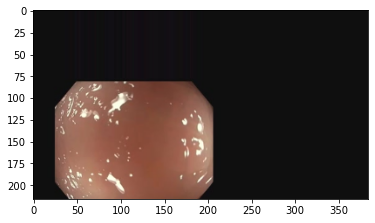

In [249]:
plt.imshow(img.permute(1,2,0).numpy())
plt.show()

In [31]:
## test dataset class
#for image, box, label in tqdm(train_ds):
#    pass

###  Dataloader

In [32]:
def collate_fn(batch):
    """
    Since each image may have a different number of objects,
    we need a collate function (to be passed to the DataLoader).
    This describes how to combine these tensors of different sizes. 
    
    images: Float tensor of dimenson Nx3xHxW
    targets: list of dictionary contains 'boxes' and 'label'
    """
    images = list()
    targets = list()
    for b in batch:
        images.append(b[0])
        target = {
            'boxes': b[1],
            'labels': b[2]
            
        }
        targets.append(target)
    images = torch.stack(images, dim=0)
    return images, targets 

In [250]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [251]:
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [252]:
images, targets = next(iter(train_dl))
images.shape # (batch, channel, height, width)

torch.Size([32, 3, 216, 384])

In [255]:
targets[:2]

[{'boxes': tensor([[  0.,   0., 384., 216.]]), 'labels': tensor([3])},
 {'boxes': tensor([[  0.,   0., 384., 216.]]), 'labels': tensor([3])}]

# Training

## SSDLite from torchvision

During training, the model expects both the input tensors (normalize image in [0-1] range),<br>
as well as a targets (list of dictionary), containing:

- boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
- labels (Int64Tensor[N]): the class label for each ground-truth box

The model returns a Dict[Tensor] during training, containing the classification and regression losses.

Sample for torchvision github
```python
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

loss_dict = model(images, targets)


>>> model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
>>> model.eval()
>>> x = [torch.rand(3, 320, 320), torch.rand(3, 500, 400)]
>>> predictions = model(x)
```

where predictions is list(Dict()) and each Dict() contains:<br>
boxes: 2D tensor<br>
scores: 1D tensor<br>
labels: 1D tensor<br>

In [37]:
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator

In [38]:
# ssdlite
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(
    pretrained=False, 
    pretrained_backbone=True,
    nms_thresh=0.25,
    iou_thresh=0.6,
    positive_fraction=0.5,
    num_classes=4)

# check layers' name
for name, layer in model.named_children():
    print(name)

# check requires_grad
for name, param in model.named_parameters():
    if param.requires_grad == False:
        print(name)

backbone
anchor_generator
head
transform


In [256]:
## setup Anchor generator here
#anchor_generator = DefaultBoxGenerator([[2], [2], [2], [2], [2], [2]], min_ratio=0.2, max_ratio=.95)
#model.anchor_generator = anchor_generator

In [257]:
# Check requires_grad
for name, param in model.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

backbone.features.0.0.0.weight gradient is set to True
backbone.features.0.0.1.weight gradient is set to True
backbone.features.0.0.1.bias gradient is set to True
backbone.features.0.1.block.0.0.weight gradient is set to True
backbone.features.0.1.block.0.1.weight gradient is set to True
backbone.features.0.1.block.0.1.bias gradient is set to True
backbone.features.0.1.block.1.0.weight gradient is set to True
backbone.features.0.1.block.1.1.weight gradient is set to True
backbone.features.0.1.block.1.1.bias gradient is set to True
backbone.features.0.2.block.0.0.weight gradient is set to True
backbone.features.0.2.block.0.1.weight gradient is set to True
backbone.features.0.2.block.0.1.bias gradient is set to True
backbone.features.0.2.block.1.0.weight gradient is set to True
backbone.features.0.2.block.1.1.weight gradient is set to True
backbone.features.0.2.block.1.1.bias gradient is set to True
backbone.features.0.2.block.2.0.weight gradient is set to True
backbone.features.0.2.bloc

In [41]:
def train_one_epoch(model, optimizer, data_loader, device, lr_scheduler=None, epoch=None, print_freq=None):
    '''
    Reference: official torchvision implementation 
    https://github.com/pytorch/vision/blob/e35793a1a4000db1f9f99673437c514e24e65451/references/detection/engine.py#L13
    
    '''
    print(f'Start Batch: {datetime.now()}')
    model.train()
    #metric_logger = utils.MetricLogger(delimiter="  ")
    #metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    #if epoch == 0:
    #    warmup_factor = 1. / 1000
    #    warmup_iters = min(1000, len(data_loader) - 1)

    #    lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    #for images, targets in metric_logger.log_every(data_loader, print_freq, header):
    for i, (images, targets) in enumerate(tqdm(data_loader)):
        model.train()
        # covert image batch (tensor) into list of images
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values()) # sum classification & regression smooth l1

        # reduce losses over all GPUs for logging purposes
        #loss_dict_reduced = utils.reduce_dict(loss_dict)
        #losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        #loss_value = losses_reduced.item()

        #if not math.isfinite(loss_value):
        #    print("Loss is {}, stopping training".format(loss_value))
        #    print(loss_dict_reduced)
        #    sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()
        if i % 1000 == 0:
            print(f'Training loss: {losses.item()}')
        #metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        #metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return None #metric_logger

In [42]:
def evaluate(model, data_loader, device):
    total_losses = 0
    model.train() # model.eval() won't calculate loss
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            #print(loss_dict)

            losses = sum(loss for loss in loss_dict.values())
            total_losses += losses
        print(f'Validation loss: {total_losses/len(data_loader)}')
    return total_losses/len(data_loader)

In [43]:
def save_checkpoint(epoch, model, optimizer):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer}
    filename = 'checkpoint_ssdlite_pretrained_backbone_v3.pth.tar'
    torch.save(state, filename)

In [44]:
# setup
EPOCHS = 2

params_to_update = []
for param in model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
optimizer = torch.optim.Adam(params_to_update, lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_dl),
    epochs=EPOCHS
)

# Train !
model.to(device)
print(f'Start training: {datetime.now()}')
start_time = time.time()

for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_dl, device, scheduler)
    evaluate(model, valid_dl, device)
    save_checkpoint(epoch, model, optimizer)

Start training: 2021-08-04 20:59:17.303527
Start Batch: 2021-08-04 20:59:17.303768


  0%|                                                                                                   | 1/34322 [00:01<10:29:11,  1.10s/it]

Training loss: 6.275263786315918


  3%|██▊                                                                                              | 1001/34322 [07:30<4:10:31,  2.22it/s]

Training loss: 0.2637280225753784


  6%|█████▋                                                                                           | 2001/34322 [14:57<3:59:51,  2.25it/s]

Training loss: 0.30604636669158936


  9%|████████▍                                                                                        | 3001/34322 [22:24<3:49:18,  2.28it/s]

Training loss: 0.3147355020046234


 12%|███████████▎                                                                                     | 4001/34322 [29:48<3:46:47,  2.23it/s]

Training loss: 0.3445751667022705


 15%|██████████████▏                                                                                  | 5001/34322 [37:09<3:29:10,  2.34it/s]

Training loss: 0.2648255228996277


 17%|████████████████▉                                                                                | 6001/34322 [44:31<3:30:11,  2.25it/s]

Training loss: 0.29111650586128235


 20%|███████████████████▊                                                                             | 7001/34322 [51:53<3:25:33,  2.22it/s]

Training loss: 0.305815190076828


 23%|██████████████████████▌                                                                          | 8001/34322 [59:13<3:09:39,  2.31it/s]

Training loss: 0.15468893945217133


 26%|████████████████████████▉                                                                      | 9001/34322 [1:06:30<3:03:07,  2.30it/s]

Training loss: 0.236228808760643


 29%|███████████████████████████▍                                                                  | 10001/34322 [1:13:51<2:57:18,  2.29it/s]

Training loss: 0.5923733711242676


 32%|██████████████████████████████▏                                                               | 11001/34322 [1:21:07<2:48:43,  2.30it/s]

Training loss: 0.17299464344978333


 35%|████████████████████████████████▊                                                             | 12001/34322 [1:28:27<2:47:37,  2.22it/s]

Training loss: 0.15344582498073578


 38%|███████████████████████████████████▌                                                          | 13001/34322 [1:35:46<2:37:40,  2.25it/s]

Training loss: 0.1868239790201187


 41%|██████████████████████████████████████▎                                                       | 14001/34322 [1:43:06<2:28:33,  2.28it/s]

Training loss: 0.1844642460346222


 44%|█████████████████████████████████████████                                                     | 15001/34322 [1:50:26<2:19:17,  2.31it/s]

Training loss: 0.17925184965133667


 47%|███████████████████████████████████████████▊                                                  | 16001/34322 [1:57:47<2:13:53,  2.28it/s]

Training loss: 0.12140069901943207


 50%|██████████████████████████████████████████████▌                                               | 17001/34322 [2:05:05<2:07:48,  2.26it/s]

Training loss: 0.15617778897285461


 52%|█████████████████████████████████████████████████▎                                            | 18001/34322 [2:12:25<2:00:19,  2.26it/s]

Training loss: 0.20737211406230927


 55%|████████████████████████████████████████████████████                                          | 19001/34322 [2:19:44<1:51:09,  2.30it/s]

Training loss: 0.15963898599147797


 58%|██████████████████████████████████████████████████████▊                                       | 20001/34322 [2:27:00<1:44:13,  2.29it/s]

Training loss: 0.5733267068862915


 61%|█████████████████████████████████████████████████████████▌                                    | 21001/34322 [2:34:13<1:37:39,  2.27it/s]

Training loss: 0.1872430145740509


 64%|████████████████████████████████████████████████████████████▎                                 | 22001/34322 [2:41:26<1:27:49,  2.34it/s]

Training loss: 0.23702526092529297


 67%|██████████████████████████████████████████████████████████████▉                               | 23001/34322 [2:48:41<1:22:11,  2.30it/s]

Training loss: 0.13991545140743256


 70%|█████████████████████████████████████████████████████████████████▋                            | 24001/34322 [2:55:56<1:14:54,  2.30it/s]

Training loss: 0.18558862805366516


 73%|████████████████████████████████████████████████████████████████████▍                         | 25001/34322 [3:03:12<1:08:16,  2.28it/s]

Training loss: 0.2410964071750641


 76%|████████████████████████████████████████████████████████████████████████▋                       | 26001/34322 [3:10:26<59:52,  2.32it/s]

Training loss: 0.15031178295612335


 79%|███████████████████████████████████████████████████████████████████████████▌                    | 27001/34322 [3:17:42<53:30,  2.28it/s]

Training loss: 0.1899077594280243


 82%|██████████████████████████████████████████████████████████████████████████████▎                 | 28001/34322 [3:24:56<46:41,  2.26it/s]

Training loss: 0.11427497863769531


 84%|█████████████████████████████████████████████████████████████████████████████████               | 29001/34322 [3:32:14<39:03,  2.27it/s]

Training loss: 0.1847110241651535


 87%|███████████████████████████████████████████████████████████████████████████████████▉            | 30001/34322 [3:39:38<31:23,  2.29it/s]

Training loss: 0.13648150861263275


 90%|██████████████████████████████████████████████████████████████████████████████████████▋         | 31001/34322 [3:46:57<24:07,  2.29it/s]

Training loss: 0.11078512668609619


 93%|█████████████████████████████████████████████████████████████████████████████████████████▌      | 32001/34322 [3:54:15<16:33,  2.34it/s]

Training loss: 0.15349571406841278


 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 33001/34322 [4:01:34<09:46,  2.25it/s]

Training loss: 0.2123311460018158


 99%|███████████████████████████████████████████████████████████████████████████████████████████████ | 34001/34322 [4:08:55<02:25,  2.20it/s]

Training loss: 0.0756712257862091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4295/4295 [1:11:53<00:00,  1.00s/it]


Validation loss: 15.760611534118652
Start Batch: 2021-08-05 02:22:28.973564


  0%|                                                                                                    | 1/34322 [00:00<4:50:13,  1.97it/s]

Training loss: 0.1259416788816452


  3%|██▊                                                                                              | 1001/34322 [07:21<3:58:06,  2.33it/s]

Training loss: 0.1663871556520462


  6%|█████▋                                                                                           | 2001/34322 [14:37<3:56:14,  2.28it/s]

Training loss: 0.14662036299705505


  9%|████████▍                                                                                        | 3001/34322 [21:53<3:47:19,  2.30it/s]

Training loss: 0.18796324729919434


 12%|███████████▎                                                                                     | 4001/34322 [29:09<3:39:00,  2.31it/s]

Training loss: 0.13697287440299988


 15%|██████████████▏                                                                                  | 5001/34322 [36:25<3:32:25,  2.30it/s]

Training loss: 0.26412636041641235


 17%|████████████████▉                                                                                | 6001/34322 [43:42<3:23:44,  2.32it/s]

Training loss: 0.16164761781692505


 20%|███████████████████▊                                                                             | 7001/34322 [50:58<3:17:49,  2.30it/s]

Training loss: 0.17324033379554749


 23%|██████████████████████▌                                                                          | 8001/34322 [58:14<3:08:17,  2.33it/s]

Training loss: 0.11049813032150269


 26%|████████████████████████▉                                                                      | 9001/34322 [1:05:30<3:06:01,  2.27it/s]

Training loss: 0.25659099221229553


 29%|███████████████████████████▍                                                                  | 10001/34322 [1:12:49<3:06:04,  2.18it/s]

Training loss: 0.1364089548587799


 32%|██████████████████████████████▏                                                               | 11001/34322 [1:20:09<2:50:21,  2.28it/s]

Training loss: 0.10666294395923615


 35%|████████████████████████████████▊                                                             | 12001/34322 [1:27:29<2:45:27,  2.25it/s]

Training loss: 0.1536370813846588


 38%|███████████████████████████████████▌                                                          | 13001/34322 [1:34:51<2:38:39,  2.24it/s]

Training loss: 0.1537693291902542


 41%|██████████████████████████████████████▎                                                       | 14001/34322 [1:42:10<2:29:03,  2.27it/s]

Training loss: 0.1401803195476532


 44%|█████████████████████████████████████████                                                     | 15001/34322 [1:49:32<2:26:46,  2.19it/s]

Training loss: 0.2024317979812622


 47%|███████████████████████████████████████████▊                                                  | 16001/34322 [1:56:54<2:18:50,  2.20it/s]

Training loss: 0.12214571237564087


 50%|██████████████████████████████████████████████▌                                               | 17001/34322 [2:04:15<2:05:48,  2.29it/s]

Training loss: 0.04053238406777382


 52%|█████████████████████████████████████████████████▎                                            | 18001/34322 [2:11:41<2:01:45,  2.23it/s]

Training loss: 0.19657766819000244


 55%|████████████████████████████████████████████████████                                          | 19001/34322 [2:19:04<1:52:46,  2.26it/s]

Training loss: 0.23503614962100983


 58%|██████████████████████████████████████████████████████▊                                       | 20001/34322 [2:26:25<1:47:25,  2.22it/s]

Training loss: 0.11111988127231598


 61%|█████████████████████████████████████████████████████████▌                                    | 21001/34322 [2:33:47<1:40:06,  2.22it/s]

Training loss: 0.11801614612340927


 64%|████████████████████████████████████████████████████████████▎                                 | 22001/34322 [2:41:08<1:28:35,  2.32it/s]

Training loss: 0.13056598603725433


 67%|██████████████████████████████████████████████████████████████▉                               | 23001/34322 [2:48:23<1:22:55,  2.28it/s]

Training loss: 0.11062122881412506


 70%|█████████████████████████████████████████████████████████████████▋                            | 24001/34322 [2:55:42<1:16:02,  2.26it/s]

Training loss: 0.07777096331119537


 73%|████████████████████████████████████████████████████████████████████▍                         | 25001/34322 [3:03:06<1:06:21,  2.34it/s]

Training loss: 0.17363618314266205


 76%|███████████████████████████████████████████████████████████████████████▏                      | 26001/34322 [3:10:30<1:01:35,  2.25it/s]

Training loss: 0.1032257229089737


 79%|███████████████████████████████████████████████████████████████████████████▌                    | 27001/34322 [3:17:46<53:15,  2.29it/s]

Training loss: 0.12525589764118195


 82%|██████████████████████████████████████████████████████████████████████████████▎                 | 28001/34322 [3:25:06<46:04,  2.29it/s]

Training loss: 0.10525165498256683


 84%|█████████████████████████████████████████████████████████████████████████████████               | 29001/34322 [3:32:24<39:32,  2.24it/s]

Training loss: 0.12847787141799927


 87%|███████████████████████████████████████████████████████████████████████████████████▉            | 30001/34322 [3:39:40<32:01,  2.25it/s]

Training loss: 0.06177256256341934


 90%|██████████████████████████████████████████████████████████████████████████████████████▋         | 31001/34322 [3:47:03<24:24,  2.27it/s]

Training loss: 0.15990102291107178


 93%|█████████████████████████████████████████████████████████████████████████████████████████▌      | 32001/34322 [3:54:20<16:44,  2.31it/s]

Training loss: 0.09501126408576965


 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 33001/34322 [4:01:35<09:40,  2.28it/s]

Training loss: 0.16037286818027496


 99%|███████████████████████████████████████████████████████████████████████████████████████████████ | 34001/34322 [4:08:50<02:19,  2.29it/s]

Training loss: 0.1348249912261963


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4295/4295 [1:11:32<00:00,  1.00it/s]


Validation loss: 18.907211303710938


In [ ]:
# 2 more epoch !
optimizer = torch.optim.Adam(params_to_update, lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_dl),
    epochs=EPOCHS
)
for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_dl, device, scheduler)
    evaluate(model, valid_dl, device)
    save_checkpoint(epoch, model, optimizer)

Start Batch: 2021-08-05 10:17:32.232500


  0%|                                                                                                    | 1/34322 [00:00<5:51:31,  1.63it/s]

Training loss: 0.07954307645559311


  3%|██▊                                                                                              | 1001/34322 [07:17<3:58:09,  2.33it/s]

Training loss: 0.09409433603286743


  6%|█████▋                                                                                           | 2001/34322 [14:32<3:55:18,  2.29it/s]

Training loss: 0.10709477961063385


  9%|████████▍                                                                                        | 3001/34322 [21:47<3:47:14,  2.30it/s]

Training loss: 0.04584907740354538


 12%|███████████▎                                                                                     | 4001/34322 [29:01<3:37:29,  2.32it/s]

Training loss: 0.11095070093870163


 15%|██████████████▏                                                                                  | 5001/34322 [36:15<3:32:06,  2.30it/s]

Training loss: 0.10410088300704956


 16%|███████████████▌                                                                                 | 5508/34322 [39:55<3:32:22,  2.26it/s]

In [261]:
# silence all score below 0.3
model.score_thresh = 0.3
torch.save(model.state_dict(), 'model/ssdlite.pth')

In [119]:
import torchvision.ops.boxes as bops

In [264]:
bops.box_iou(target[0]['boxes'], predictions[0]['boxes'].cpu())

tensor([[0.6420]])